In [1]:
using PyPlot

using Distributed
using SharedArrays

addprocs(4)

@everywhere include("../src/num.jl")
@everywhere include("../src/phy.jl")
using .num
using .physics

@everywhere using DSP

In [2]:
const t = 0.5
U = 3.2
T = 0.0
const nωn = 2^12
const nω = 2^12
ωrange = [-4.0,4.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.80;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

In [4]:
@time D0ω = baredos.("bethe",t,ω);
gloc = zeros(ComplexF64,nω,2);

  0.487252 seconds (1.74 M allocations: 90.455 MiB, 6.23% gc time)


In [5]:
@everywhere function ipt_solver(Aw, nf, U)
    AA  = num.conv_same(Aw[:,1] .* nf,Aw[:,2] .* nf)
    AAB = num.conv_same(AA,Aw[:,2] .* nf)

    BB  = num.conv_same(Aw[:,1] .* nf,Aw[:,2] .* nf)
    BBA = num.conv_same(BB,Aw[:,2] .* nf)

    return -π .* U^2 .* (AAB + BBA)
end

@everywhere function ipt_selfcons(ω,gloc,dos,t,U,T,itermax,nω,zeroplus,mix,tol)
        g0 = zeros(ComplexF64,size(gloc))
        isi = zeros(Float64,size(gloc))
        hsi = zeros(Float64,size(gloc))
        A0 = zeros(Float64,size(gloc))
        Σ2 = zeros(ComplexF64,size(gloc))

        magnet = 0.0

        dω = ω[2] - ω[1]

        nf = physics.fermi.(ω,T)

        η = zeroplus
        α = mix

        ρe = dos[1:4:nω]
        w  = ω[1:4:nω]

        Σ1 = U .* [0.0 -0.0]
    
        for i = 1:nω
            ζ_up = physics.zeta(ω[i] - Σ1[1],η)
            ζ_down = physics.zeta(ω[i] - Σ1[2],η)
        
            intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
            sum = num.trapz(w,intg)
        
            gloc[i,1] = sum * ζ_down
            gloc[i,2] = sum * ζ_up
        end
        
        for iter = 1:itermax

            gloc_old = deepcopy(gloc)

            ncalc = zeros(Float64,length(gloc[1,:]))
            for i in 1:length(gloc[1,:])
                intg = -1/π .* imag(gloc_old[:,i]) .* nf
                ncalc[i] = num.trapz(ω,intg) 
            end
        
            Σ1[1] = U .* (ncalc[2] - sum(ncalc)/2)
            Σ1[2] = U .* (ncalc[1] - sum(ncalc)/2)
            magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)
        
            g0[:,1] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,2])
            g0[:,2] = 1. ./ (ω .+ im*η .- t^2 .* gloc_old[:,1])
            
            for i = 1:length(gloc[1,:]) A0[:,i] = -imag(g0[:,i]) ./ π end

            
            #isi[:,1] = ipt_solver(A0[:,1],A0[:,2],nf,U) * dω * dω
            #isi[:,2] = ipt_solver(A0[:,1],A0[:,2],nf,U) * dω * dω
            for i = 1:length(gloc[1,:])
                isi[:,i] = ipt_solver(A0,nf,U) * dω * dω
                isi[:,i] = 0.5 .* (isi[:,i] + isi[end:-1:1,i])
                hsi[:,i] = -imag.(Util.hilbert(isi[:,i]))
            end

            Σ2 = hsi .+ im .* isi

            for i = 1:nω
                ζ_up = physics.zeta(ω[i] - Σ1[1] .- Σ2[i,1],η)
                ζ_down = physics.zeta(ω[i] - Σ1[2] .- Σ2[i,2],η)

                intg = ρe ./ (ζ_up*ζ_down .- w.^2.)
                sum = num.trapz(w,intg)

                gloc[i,1] = sum * ζ_down
                gloc[i,2] = sum * ζ_up
            end

            convg, error = num.convergent(gloc_old,gloc,ω,nω,tol)

            if convg == false
                gloc = num.mixing(gloc_old,gloc,mix)
            elseif iter == itermax
                println("Convergent is not achieved. Try Lower Mixings or Higher Iterations")
                break
            elseif convg == true
                println("Convergent is achieved for U = $U, and T = $T K")
                break
            end
        end

        return gloc,Σ1,Σ2,magnet

end;

In [6]:
nU = 40
U = range(0.0, length=nU,stop=4.0)
U = convert(Array{Float64},U)

nT = 50
T = range(0.0, length=nT,stop=1200)
T = convert(Array{Float64},T)


glocr = SharedArray{ComplexF64}(nω,2,nU,nT)
Σ2 = SharedArray{ComplexF64}(nω,2,nU,nT)

@inbounds @sync @distributed for iU in 1:nU
    for iT in 1:nT
        glocr[:,:,iU,iT],Σ1,Σ2[:,:,iU,iT],magnet =  ipt_selfcons(ω,gloc,D0ω,t,U[iU],T[iT],itermax,nω,zeroplus,mix,tol)
    end
end

      From worker 2:	Convergent is achieved for U = 0.0, and T = 0.0 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 24.489795918367346 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 48.97959183673469 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 73.46938775510205 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 97.95918367346938 K
      From worker 3:	Convergent is achieved for U = 1.0256410256410255, and T = 0.0 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 122.44897959183673 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 146.9387755102041 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 171.42857142857142 K
      From worker 2:	Convergent is achieved for U = 0.0, and T = 195.91836734693877 K
      From worker 4:	Convergent is achieved for U = 2.051282051282051, and T = 0.0 K
      From worker 3:	Convergent is achieved for U = 1.0256410256410255, an

      From worker 2:	Convergent is achieved for U = 0.10256410256410256, and T = 195.91836734693877 K
      From worker 5:	Convergent is achieved for U = 3.076923076923077, and T = 97.95918367346938 K
      From worker 2:	Convergent is achieved for U = 0.10256410256410256, and T = 220.40816326530611 K
      From worker 3:	Convergent is achieved for U = 1.0256410256410255, and T = 416.3265306122449 K
      From worker 2:	Convergent is achieved for U = 0.10256410256410256, and T = 244.89795918367346 K
      From worker 4:	Convergent is achieved for U = 2.051282051282051, and T = 269.38775510204084 K
      From worker 2:	Convergent is achieved for U = 0.10256410256410256, and T = 269.38775510204084 K
      From worker 3:	Convergent is achieved for U = 1.0256410256410255, and T = 440.81632653061223 K
      From worker 2:	Convergent is achieved for U = 0.10256410256410256, and T = 293.8775510204082 K
      From worker 2:	Convergent is achieved for U = 0.10256410256410256, and T = 318.367346

      From worker 3:	Convergent is achieved for U = 1.0256410256410255, and T = 881.6326530612245 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 73.46938775510205 K
      From worker 4:	Convergent is achieved for U = 2.051282051282051, and T = 563.265306122449 K
      From worker 3:	Convergent is achieved for U = 1.0256410256410255, and T = 906.1224489795918 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 97.95918367346938 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 122.44897959183673 K
      From worker 3:	Convergent is achieved for U = 1.0256410256410255, and T = 930.6122448979592 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 146.9387755102041 K
      From worker 4:	Convergent is achieved for U = 2.051282051282051, and T = 587.7551020408164 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 171.4285714285714

      From worker 3:	Convergent is achieved for U = 1.1282051282051282, and T = 244.89795918367346 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 1077.5510204081634 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 1102.0408163265306 K
      From worker 3:	Convergent is achieved for U = 1.1282051282051282, and T = 269.38775510204084 K
      From worker 4:	Convergent is achieved for U = 2.051282051282051, and T = 881.6326530612245 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 1126.530612244898 K
      From worker 5:	Convergent is achieved for U = 3.076923076923077, and T = 342.85714285714283 K
      From worker 3:	Convergent is achieved for U = 1.1282051282051282, and T = 293.8775510204082 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 1151.0204081632653 K
      From worker 2:	Convergent is achieved for U = 0.20512820512820512, and T = 1175.510204

      From worker 2:	Convergent is achieved for U = 0.3076923076923077, and T = 710.204081632653 K
      From worker 2:	Convergent is achieved for U = 0.3076923076923077, and T = 734.6938775510204 K
      From worker 3:	Convergent is achieved for U = 1.1282051282051282, and T = 881.6326530612245 K
      From worker 2:	Convergent is achieved for U = 0.3076923076923077, and T = 759.1836734693877 K
      From worker 4:	Convergent is achieved for U = 2.051282051282051, and T = 1200.0 K
      From worker 3:	Convergent is achieved for U = 1.1282051282051282, and T = 906.1224489795918 K
      From worker 2:	Convergent is achieved for U = 0.3076923076923077, and T = 783.6734693877551 K
      From worker 5:	Convergent is achieved for U = 3.076923076923077, and T = 563.265306122449 K
      From worker 2:	Convergent is achieved for U = 0.3076923076923077, and T = 808.1632653061224 K
      From worker 3:	Convergent is achieved for U = 1.1282051282051282, and T = 930.6122448979592 K
      From work

      From worker 2:	Convergent is achieved for U = 0.41025641025641024, and T = 342.85714285714283 K
      From worker 3:	Convergent is achieved for U = 1.2307692307692308, and T = 244.89795918367346 K
      From worker 2:	Convergent is achieved for U = 0.41025641025641024, and T = 367.3469387755102 K
      From worker 5:	Convergent is achieved for U = 3.076923076923077, and T = 808.1632653061224 K
      From worker 4:	Convergent is achieved for U = 2.1538461538461537, and T = 342.85714285714283 K
      From worker 3:	Convergent is achieved for U = 1.2307692307692308, and T = 269.38775510204084 K
      From worker 2:	Convergent is achieved for U = 0.41025641025641024, and T = 391.83673469387753 K
      From worker 2:	Convergent is achieved for U = 0.41025641025641024, and T = 416.3265306122449 K
      From worker 3:	Convergent is achieved for U = 1.2307692307692308, and T = 293.8775510204082 K
      From worker 4:	Convergent is achieved for U = 2.1538461538461537, and T = 367.34693877

      From worker 5:	Convergent is achieved for U = 3.076923076923077, and T = 1077.5510204081634 K
      From worker 4:	Convergent is achieved for U = 2.1538461538461537, and T = 661.2244897959183 K
      From worker 2:	Convergent is achieved for U = 0.41025641025641024, and T = 1175.5102040816328 K
      From worker 3:	Convergent is achieved for U = 1.2307692307692308, and T = 832.6530612244898 K
      From worker 2:	Convergent is achieved for U = 0.41025641025641024, and T = 1200.0 K
      From worker 3:	Convergent is achieved for U = 1.2307692307692308, and T = 857.1428571428571 K
      From worker 2:	Convergent is achieved for U = 0.5128205128205128, and T = 0.0 K
      From worker 5:	Convergent is achieved for U = 3.076923076923077, and T = 1102.0408163265306 K
      From worker 4:	Convergent is achieved for U = 2.1538461538461537, and T = 685.7142857142857 K
      From worker 3:	Convergent is achieved for U = 1.2307692307692308, and T = 881.6326530612245 K
      From worker 2:	C

      From worker 3:	Convergent is achieved for U = 1.3333333333333333, and T = 195.91836734693877 K
      From worker 4:	Convergent is achieved for U = 2.1538461538461537, and T = 955.1020408163265 K
      From worker 2:	Convergent is achieved for U = 0.5128205128205128, and T = 857.1428571428571 K
      From worker 2:	Convergent is achieved for U = 0.5128205128205128, and T = 881.6326530612245 K
      From worker 3:	Convergent is achieved for U = 1.3333333333333333, and T = 220.40816326530611 K
      From worker 2:	Convergent is achieved for U = 0.5128205128205128, and T = 906.1224489795918 K
      From worker 3:	Convergent is achieved for U = 1.3333333333333333, and T = 244.89795918367346 K
      From worker 4:	Convergent is achieved for U = 2.1538461538461537, and T = 979.5918367346939 K
      From worker 2:	Convergent is achieved for U = 0.5128205128205128, and T = 930.6122448979592 K
      From worker 2:	Convergent is achieved for U = 0.5128205128205128, and T = 955.1020408163265

      From worker 3:	Convergent is achieved for U = 1.3333333333333333, and T = 808.1632653061224 K
      From worker 2:	Convergent is achieved for U = 0.6153846153846154, and T = 612.2448979591836 K
      From worker 2:	Convergent is achieved for U = 0.6153846153846154, and T = 636.734693877551 K
      From worker 3:	Convergent is achieved for U = 1.3333333333333333, and T = 832.6530612244898 K
      From worker 4:	Convergent is achieved for U = 2.2564102564102564, and T = 97.95918367346938 K
      From worker 2:	Convergent is achieved for U = 0.6153846153846154, and T = 661.2244897959183 K
      From worker 2:	Convergent is achieved for U = 0.6153846153846154, and T = 685.7142857142857 K
      From worker 3:	Convergent is achieved for U = 1.3333333333333333, and T = 857.1428571428571 K
      From worker 4:	Convergent is achieved for U = 2.2564102564102564, and T = 122.44897959183673 K
      From worker 2:	Convergent is achieved for U = 0.6153846153846154, and T = 710.204081632653 K
 

      From worker 4:	Convergent is achieved for U = 2.2564102564102564, and T = 465.3061224489796 K
      From worker 3:	Convergent is achieved for U = 1.435897435897436, and T = 171.42857142857142 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 293.8775510204082 K
      From worker 3:	Convergent is achieved for U = 1.435897435897436, and T = 195.91836734693877 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 318.3673469387755 K
      From worker 4:	Convergent is achieved for U = 2.2564102564102564, and T = 489.7959183673469 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 342.85714285714283 K
      From worker 3:	Convergent is achieved for U = 1.435897435897436, and T = 220.40816326530611 K
      From worker 5:	Convergent is achieved for U = 3.1794871794871793, and T = 391.83673469387753 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 367.3469387755102 K
  

      From worker 3:	Convergent is achieved for U = 1.435897435897436, and T = 783.6734693877551 K
      From worker 4:	Convergent is achieved for U = 2.2564102564102564, and T = 783.6734693877551 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 1126.530612244898 K
      From worker 3:	Convergent is achieved for U = 1.435897435897436, and T = 808.1632653061224 K
      From worker 5:	Convergent is achieved for U = 3.1794871794871793, and T = 661.2244897959183 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 1151.0204081632653 K
      From worker 3:	Convergent is achieved for U = 1.435897435897436, and T = 832.6530612244898 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 1175.5102040816328 K
      From worker 4:	Convergent is achieved for U = 2.2564102564102564, and T = 808.1632653061224 K
      From worker 2:	Convergent is achieved for U = 0.717948717948718, and T = 1200.0 K
      From worke

      From worker 3:	Convergent is achieved for U = 1.5384615384615385, and T = 171.42857142857142 K
      From worker 2:	Convergent is achieved for U = 0.8205128205128205, and T = 710.204081632653 K
      From worker 5:	Convergent is achieved for U = 3.1794871794871793, and T = 979.5918367346939 K
      From worker 3:	Convergent is achieved for U = 1.5384615384615385, and T = 195.91836734693877 K
      From worker 2:	Convergent is achieved for U = 0.8205128205128205, and T = 734.6938775510204 K
      From worker 4:	Convergent is achieved for U = 2.2564102564102564, and T = 1077.5510204081634 K
      From worker 2:	Convergent is achieved for U = 0.8205128205128205, and T = 759.1836734693877 K
      From worker 3:	Convergent is achieved for U = 1.5384615384615385, and T = 220.40816326530611 K
      From worker 2:	Convergent is achieved for U = 0.8205128205128205, and T = 783.6734693877551 K
      From worker 5:	Convergent is achieved for U = 3.1794871794871793, and T = 1004.081632653061

      From worker 3:	Convergent is achieved for U = 1.5384615384615385, and T = 759.1836734693877 K
      From worker 2:	Convergent is achieved for U = 0.9230769230769231, and T = 293.8775510204082 K
      From worker 4:	Convergent is achieved for U = 2.358974358974359, and T = 195.91836734693877 K
      From worker 2:	Convergent is achieved for U = 0.9230769230769231, and T = 318.3673469387755 K
      From worker 3:	Convergent is achieved for U = 1.5384615384615385, and T = 783.6734693877551 K
      From worker 2:	Convergent is achieved for U = 0.9230769230769231, and T = 342.85714285714283 K
      From worker 4:	Convergent is achieved for U = 2.358974358974359, and T = 220.40816326530611 K
      From worker 3:	Convergent is achieved for U = 1.5384615384615385, and T = 808.1632653061224 K
      From worker 2:	Convergent is achieved for U = 0.9230769230769231, and T = 367.3469387755102 K
      From worker 2:	Convergent is achieved for U = 0.9230769230769231, and T = 391.83673469387753 

      From worker 2:	Convergent is achieved for U = 0.9230769230769231, and T = 1175.5102040816328 K
      From worker 3:	Convergent is achieved for U = 1.641025641025641, and T = 146.9387755102041 K
      From worker 2:	Convergent is achieved for U = 0.9230769230769231, and T = 1200.0 K
      From worker 3:	Convergent is achieved for U = 1.641025641025641, and T = 171.42857142857142 K
      From worker 4:	Convergent is achieved for U = 2.358974358974359, and T = 587.7551020408164 K
      From worker 3:	Convergent is achieved for U = 1.641025641025641, and T = 195.91836734693877 K
      From worker 3:	Convergent is achieved for U = 1.641025641025641, and T = 220.40816326530611 K
      From worker 5:	Convergent is achieved for U = 3.282051282051282, and T = 195.91836734693877 K
      From worker 4:	Convergent is achieved for U = 2.358974358974359, and T = 612.2448979591836 K
      From worker 3:	Convergent is achieved for U = 1.641025641025641, and T = 244.89795918367346 K
      From wo

      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 0.0 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 24.489795918367346 K
      From worker 4:	Convergent is achieved for U = 2.358974358974359, and T = 1053.061224489796 K
      From worker 5:	Convergent is achieved for U = 3.282051282051282, and T = 636.734693877551 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 48.97959183673469 K
      From worker 4:	Convergent is achieved for U = 2.358974358974359, and T = 1077.5510204081634 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 73.46938775510205 K
      From worker 5:	Convergent is achieved for U = 3.282051282051282, and T = 661.2244897959183 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 97.95918367346938 K
      From worker 4:	Convergent is achieved for U = 2.358974358974359, and T = 1102.0408163265306 K
      From worker

      From worker 4:	Convergent is achieved for U = 2.4615384615384617, and T = 367.3469387755102 K
      From worker 5:	Convergent is achieved for U = 3.282051282051282, and T = 1175.5102040816328 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 955.1020408163265 K
      From worker 4:	Convergent is achieved for U = 2.4615384615384617, and T = 391.83673469387753 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 979.5918367346939 K
      From worker 5:	Convergent is achieved for U = 3.282051282051282, and T = 1200.0 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 1004.0816326530612 K
      From worker 4:	Convergent is achieved for U = 2.4615384615384617, and T = 416.3265306122449 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 1028.5714285714287 K
      From worker 3:	Convergent is achieved for U = 1.7435897435897436, and T = 1053.061224489796 K
      Fro

      From worker 4:	Convergent is achieved for U = 2.4615384615384617, and T = 881.6326530612245 K
      From worker 3:	Convergent is achieved for U = 1.8461538461538463, and T = 930.6122448979592 K
      From worker 5:	Convergent is achieved for U = 3.3846153846153846, and T = 269.38775510204084 K
      From worker 3:	Convergent is achieved for U = 1.8461538461538463, and T = 955.1020408163265 K
      From worker 4:	Convergent is achieved for U = 2.4615384615384617, and T = 906.1224489795918 K
      From worker 3:	Convergent is achieved for U = 1.8461538461538463, and T = 979.5918367346939 K
      From worker 5:	Convergent is achieved for U = 3.3846153846153846, and T = 293.8775510204082 K
      From worker 3:	Convergent is achieved for U = 1.8461538461538463, and T = 1004.0816326530612 K
      From worker 4:	Convergent is achieved for U = 2.4615384615384617, and T = 930.6122448979592 K
      From worker 3:	Convergent is achieved for U = 1.8461538461538463, and T = 1028.5714285714287

      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 220.40816326530611 K
      From worker 3:	Convergent is achieved for U = 1.9487179487179487, and T = 636.734693877551 K
      From worker 5:	Convergent is achieved for U = 3.3846153846153846, and T = 808.1632653061224 K
      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 244.89795918367346 K
      From worker 3:	Convergent is achieved for U = 1.9487179487179487, and T = 661.2244897959183 K
      From worker 3:	Convergent is achieved for U = 1.9487179487179487, and T = 685.7142857142857 K
      From worker 5:	Convergent is achieved for U = 3.3846153846153846, and T = 832.6530612244898 K
      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 269.38775510204084 K
      From worker 3:	Convergent is achieved for U = 1.9487179487179487, and T = 710.204081632653 K
      From worker 5:	Convergent is achieved for U = 3.3846153846153846, and T = 857.1428571428571 K

      From worker 5:	Convergent is achieved for U = 3.4871794871794872, and T = 293.8775510204082 K
      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 955.1020408163265 K
      From worker 5:	Convergent is achieved for U = 3.4871794871794872, and T = 318.3673469387755 K
      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 979.5918367346939 K
      From worker 5:	Convergent is achieved for U = 3.4871794871794872, and T = 342.85714285714283 K
      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 1004.0816326530612 K
      From worker 5:	Convergent is achieved for U = 3.4871794871794872, and T = 367.3469387755102 K
      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 1028.5714285714287 K
      From worker 4:	Convergent is achieved for U = 2.5641025641025643, and T = 1053.061224489796 K
      From worker 5:	Convergent is achieved for U = 3.4871794871794872, and T = 391.8367346938775

      From worker 4:	Convergent is achieved for U = 2.6666666666666665, and T = 661.2244897959183 K
      From worker 4:	Convergent is achieved for U = 2.6666666666666665, and T = 685.7142857142857 K
      From worker 5:	Convergent is achieved for U = 3.58974358974359, and T = 171.42857142857142 K
      From worker 4:	Convergent is achieved for U = 2.6666666666666665, and T = 710.204081632653 K
      From worker 5:	Convergent is achieved for U = 3.58974358974359, and T = 195.91836734693877 K
      From worker 4:	Convergent is achieved for U = 2.6666666666666665, and T = 734.6938775510204 K
      From worker 5:	Convergent is achieved for U = 3.58974358974359, and T = 220.40816326530611 K
      From worker 4:	Convergent is achieved for U = 2.6666666666666665, and T = 759.1836734693877 K
      From worker 5:	Convergent is achieved for U = 3.58974358974359, and T = 244.89795918367346 K
      From worker 4:	Convergent is achieved for U = 2.6666666666666665, and T = 783.6734693877551 K
     

      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 24.489795918367346 K
      From worker 4:	Convergent is achieved for U = 2.769230769230769, and T = 416.3265306122449 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 48.97959183673469 K
      From worker 4:	Convergent is achieved for U = 2.769230769230769, and T = 440.81632653061223 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 73.46938775510205 K
      From worker 4:	Convergent is achieved for U = 2.769230769230769, and T = 465.3061224489796 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 97.95918367346938 K
      From worker 4:	Convergent is achieved for U = 2.769230769230769, and T = 489.7959183673469 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 122.44897959183673 K
      From worker 4:	Convergent is achieved for U = 2.769230769230769, and T = 514.2857142857143 K
  

      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 1077.5510204081634 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 171.42857142857142 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 1102.0408163265306 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 1126.530612244898 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 195.91836734693877 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 1151.0204081632653 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 220.40816326530611 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 1175.5102040816328 K
      From worker 5:	Convergent is achieved for U = 3.6923076923076925, and T = 1200.0 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 244.89795918367346 K
      F

      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 1102.0408163265306 K
      From worker 5:	Convergent is achieved for U = 3.7948717948717947, and T = 955.1020408163265 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 1126.530612244898 K
      From worker 5:	Convergent is achieved for U = 3.7948717948717947, and T = 979.5918367346939 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 1151.0204081632653 K
      From worker 5:	Convergent is achieved for U = 3.7948717948717947, and T = 1004.0816326530612 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 1175.5102040816328 K
      From worker 5:	Convergent is achieved for U = 3.7948717948717947, and T = 1028.5714285714287 K
      From worker 4:	Convergent is achieved for U = 2.871794871794872, and T = 1200.0 K
      From worker 5:	Convergent is achieved for U = 3.7948717948717947, and T = 1053.061224489796 K
      From 

      From worker 4:	Convergent is achieved for U = 2.9743589743589745, and T = 759.1836734693877 K
      From worker 5:	Convergent is achieved for U = 3.8974358974358974, and T = 881.6326530612245 K
      From worker 4:	Convergent is achieved for U = 2.9743589743589745, and T = 783.6734693877551 K
      From worker 5:	Convergent is achieved for U = 3.8974358974358974, and T = 906.1224489795918 K
      From worker 4:	Convergent is achieved for U = 2.9743589743589745, and T = 808.1632653061224 K
      From worker 5:	Convergent is achieved for U = 3.8974358974358974, and T = 930.6122448979592 K
      From worker 4:	Convergent is achieved for U = 2.9743589743589745, and T = 832.6530612244898 K
      From worker 5:	Convergent is achieved for U = 3.8974358974358974, and T = 955.1020408163265 K
      From worker 4:	Convergent is achieved for U = 2.9743589743589745, and T = 857.1428571428571 K
      From worker 5:	Convergent is achieved for U = 3.8974358974358974, and T = 979.5918367346939 K


Task (done) @0x00007f49909edf90

In [219]:
phase = -imag(glocr[Int64(4096/2),:,:,:])
phase = reshape(sum(phase,dims=1),40,50)
phase = transpose(phase[:,end:-1:1]);
phase = convert(Array{Float64,2},phase);

In [220]:
using JLD2
@save "ipt_ph_diagram_param.jld2" phase U T

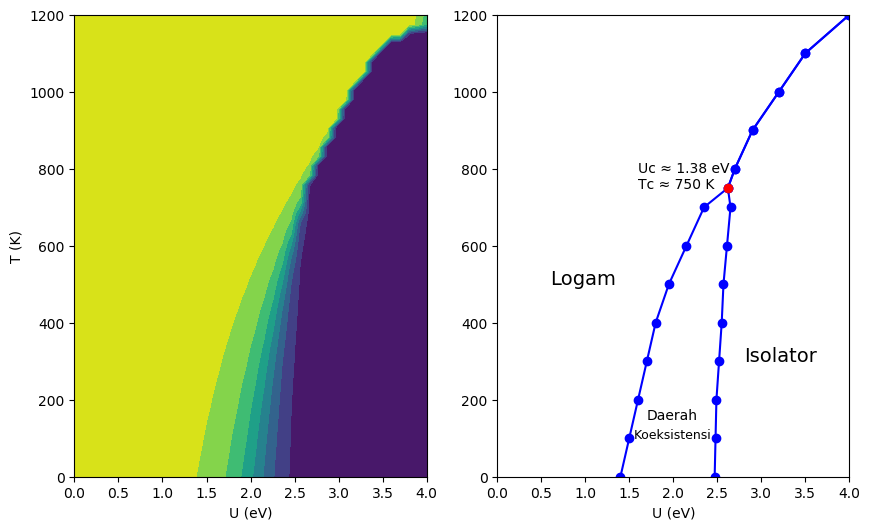

In [221]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.contourf(U,T,phase,cmap="viridis")
plt.xlim(0.,4.0)
plt.ylim(0,1200)
plt.ylabel("T (K)")
plt.xlabel("U (eV)")

plt.subplot(1,2,2)
y = [1200, 1100, 1000, 900, 800, 750, 700, 600, 500, 400, 300, 200, 100, 0]
x1 = [0.0, 0.5, 0.8, 1.1, 1.3, 1.38, 1.35, 1.39, 1.43, 1.45, 1.48, 1.51, 1.52, 1.53]
x2 = [0.0, 0.5, 0.8, 1.1, 1.3, 1.38, 1.65, 1.85, 2.05, 2.2, 2.3, 2.4, 2.5, 2.6]
plt.plot(4.0 .- x1,y,"-o",color="blue")
plt.plot(4.0 .- x2,y,"-o",color="blue")
plt.plot(4.0 .- 1.38,750,"-o",color="red")
plt.xlim(0.,4.0)
plt.ylim(0,1200)
plt.xlabel("U (eV)")

plt.text(0.6,500,"Logam",fontsize=14)
plt.text(1.7,150,"Daerah")
plt.text(1.55,100,"Koeksistensi",fontsize=9)
plt.text(2.8,300,"Isolator",fontsize=14)
plt.text(1.6, 750, "Tc ≈ 750 K")
plt.text(1.6, 790, "Uc ≈ 1.38 eV")

plt.show()
plt.savefig("ipt_ph_diagram_param.pdf",format="pdf")